Detección de compras frecuentes
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/predictive-analytics/blob/master/12-apriori-R-purchased-groceries.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/predictive-analytics/blob/master/12-apriori-R-purchased-groceries.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/predictive-analytics/blob/master/LICENSE)  
[Readme](https://github.com/jdvelasq/predictive-analytics/blob/master/readme.md)

# Definición del problema real

Una cadena de supermercados desea construir un sistema de recomendación para su página web que sugiera a un comprador otros productos que podrían interesarle dependiendo de la búsqueda o la selección de productos que haya realizado en un momento determinado.

# Definición del problema en términos de los datos

Se tiene una base de datos de 9835 transacciones recolectadas de forma continua durante 12 días para un supermercado relativamente pequeño. Para hacer este problema manejable no se tuvieron en cuenta las posibles marcas de un mismo producto ni los distintos tipos de presentaciones. De esta forma, se tienen registros de 169 tipos de productos como `chicken`, `frozen meals`, `margarine`, etc. El objetivo en términos de los datos consiste en determinar los grupos de productos que se compran frecuentemente juntos con el fin de que cuando un cliente seleccione uno o más items de un determinado grupo, los restantes elementos le sean sugeridos automáticamente por el sistema.  

# Exploración

In [ ]:
## Carga de los datos
## install.packages("arules")
## library(arules)

In [ ]:
## groceries <- read.transactions("data/groceries.csv", sep = ",")

El archivo anterior contiene una transacción por fila, y los items comprados por transacción aparecen separados por coma:

    citrus fruit,semi-finished bread,margarine,ready soups 
    tropical fruit,yogurt,coffee
    whole milk
    pip fruit,yogurt,cream cheese ,meat spreads
    other vegetables,whole milk,condensed milk,long life bakery product
    whole milk,butter,yogurt,rice,abrasive cleaner
    rolls/buns
    other vegetables,UHT-milk,rolls/buns,bottled beer,liquor (appetizer)
    pot plants
    whole milk,cereals
    
Una de las dificultades para manejar esta información es que cada fila puede contener un número diferente de elementos por lo que no es posible usar directamente un data.frame y se utiliza una matriz esparcida. 

In [ ]:
## Se obtiene la información más relevante de los datos
## summary(groceries)

## transactions as itemMatrix in sparse format with
##  9835 rows (elements/itemsets/transactions) and
##  169 columns (items) and a density of 0.02609146 
## 
## most frequent items:
##       whole milk other vegetables       rolls/buns             soda 
##             2513             1903             1809             1715 
##           yogurt          (Other) 
##             1372            34055 
## 
## element (itemset/transaction) length distribution:
## sizes
##    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
## 2159 1643 1299 1005  855  645  545  438  350  246  182  117   78   77   55   46 
##   17   18   19   20   21   22   23   24   26   27   28   29   32 
##   29   14   14    9   11    4    6    1    1    1    1    3    1 
## 
##    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
##   1.000   2.000   3.000   4.409   6.000  32.000 
## 
## includes extended item information - examples:
##             labels
## 1 abrasive cleaner
## 2 artif. sweetener
## 3   baby cosmetics

transactions as itemMatrix in sparse format with
 9835 rows (elements/itemsets/transactions) and
 169 columns (items) and a density of 0.02609146 

most frequent items:
      whole milk other vegetables       rolls/buns             soda 
            2513             1903             1809             1715 
          yogurt          (Other) 
            1372            34055 

element (itemset/transaction) length distribution:
sizes
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2159 1643 1299 1005  855  645  545  438  350  246  182  117   78   77   55   46 
  17   18   19   20   21   22   23   24   26   27   28   29   32 
  29   14   14    9   11    4    6    1    1    1    1    3    1 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  1.000   2.000   3.000   4.409   6.000  32.000 

includes extended item information - examples:
            labels
1 abrasive cleaner
2 artif. sweetener
3   baby cosmetics

La segunda parte de la tabla anterior indica la cantidad de transacciones que tienen un solo item, luego dos y así sucesivamente.
 
    element (itemset/transaction) length distribution:
    sizes
       1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
    2159 1643 1299 1005  855  645  545  438  350  246  182  117   78   77   55   46 

      17   18   19   20   21   22   23   24   26   27   28   29   32 
      29   14   14    9   11    4    6    1    1    1    1    3    1 

Esta misma tabla indica que hay una transacción en que se compraron 32 items.

In [ ]:
## Se visualizan los items comprados en las primeras
## cinco transacciones (filas del archivo)
## inspect(groceries[1:5])

##     items                     
## [1] {citrus fruit,            
##      margarine,               
##      ready soups,             
##      semi-finished bread}     
## [2] {coffee,                  
##      tropical fruit,          
##      yogurt}                  
## [3] {whole milk}              
## [4] {cream cheese,            
##      meat spreads,            
##      pip fruit,               
##      yogurt}                  
## [5] {condensed milk,          
##      long life bakery product,
##      other vegetables,        
##      whole milk}              
## 

    items                     
[1] {citrus fruit,            
     margarine,               
     ready soups,             
     semi-finished bread}     
[2] {coffee,                  
     tropical fruit,          
     yogurt}                  
[3] {whole milk}              
[4] {cream cheese,            
     meat spreads,            
     pip fruit,               
     yogurt}                  
[5] {condensed milk,          
     long life bakery product,
     other vegetables,        
     whole milk}              


In [ ]:
## Se imprime la frequencia con que se compraron los primeros 
## tres items (note que esta organizado alfabeticamente)
## itemFrequency(groceries[, 1:3])

## abrasive cleaner artif. sweetener   baby cosmetics 
##     0.0035587189     0.0032536858     0.0006100661 

abrasive cleaner artif. sweetener   baby cosmetics 
    0.0035587189     0.0032536858     0.0006100661

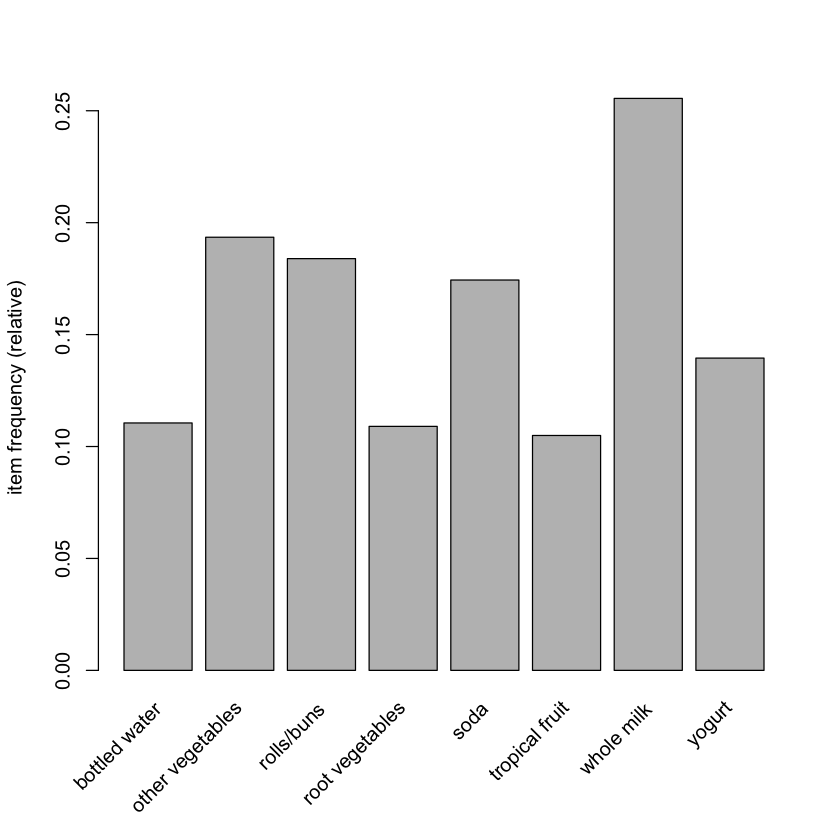

In [ ]:
## Se grafica un histograma que muestra la frecuencia
## con que se compraron ciertos items. El parámetro
## `support`  corresponde a la frecuencia mínima que
## deben tener un item para que sea incluído en la gráfica.
## En este caso un item debe aparecer en 0.1 * 9385 = 938.5
## transacciones para ser tenido en cuenta.
## itemFrequencyPlot(groceries, support = 0.1)

## plot without title

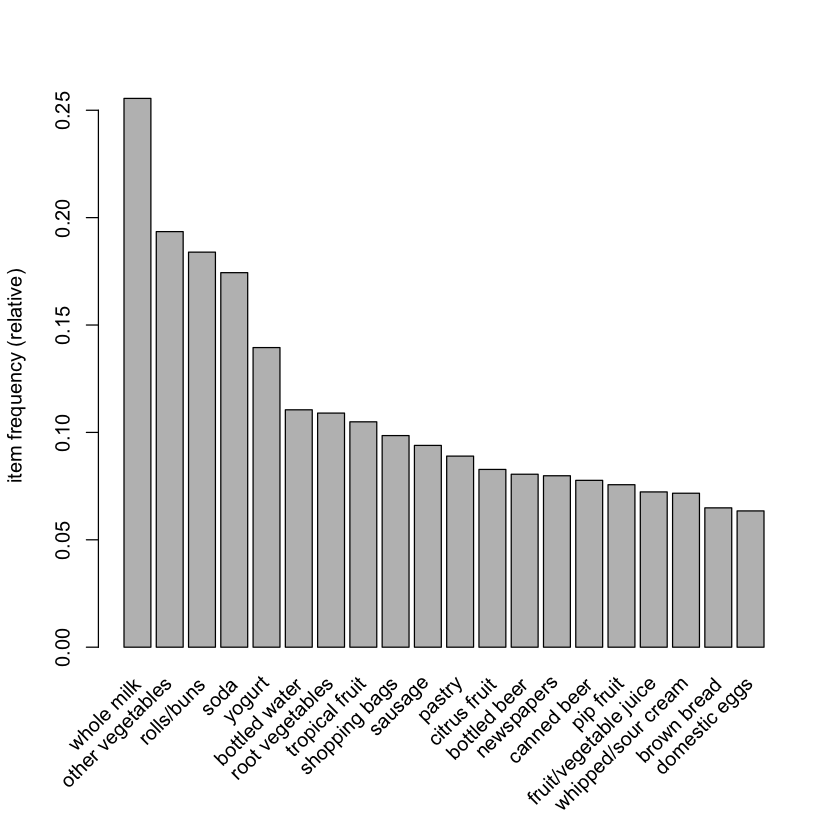

In [ ]:
## Se obtiene la misma gráfica anterior pero para los 
## 20 items más comprados.
## itemFrequencyPlot(groceries, topN = 20)

## plot without title

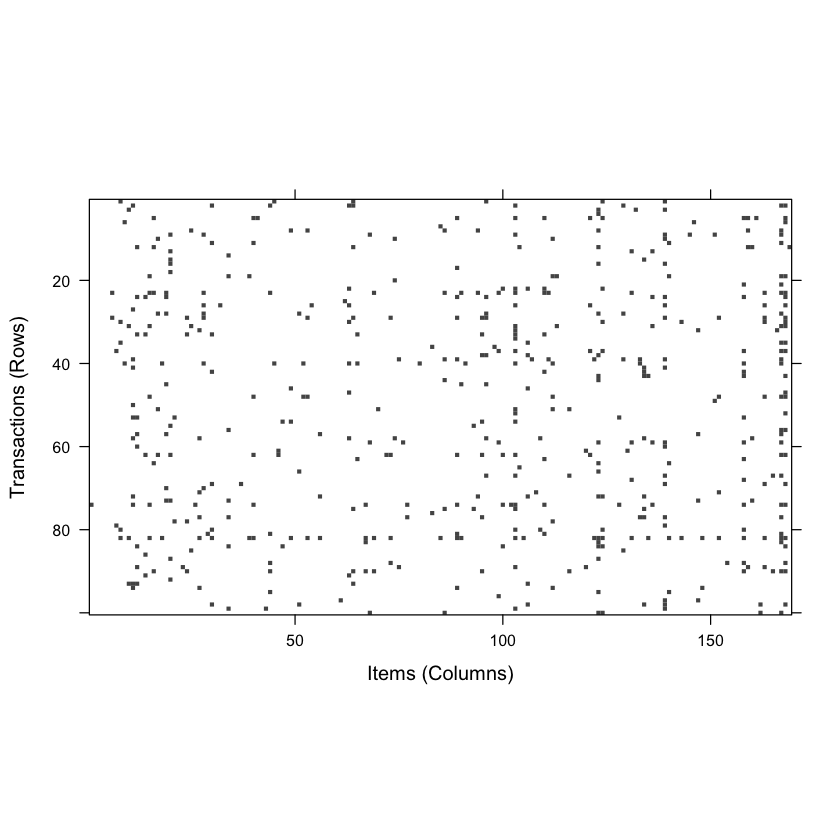

In [ ]:
## Se puede visualizar la matriz de items
## y transacciones para una muestra aleatoria.
## Una linea vertical muestra items que podrían ser 
## comprados en cada transacción
## image(sample(groceries, 100))

## plot without title

# Metodología

Una transacción se representa a través del conjunto de ítems comprados en ella. Así, una transacción con cuatro ítems se representa como:

$$\{ x_1, x_2, x_3, x_4 \}$$

El objetivo del sistema de recomendación es construir una regla de asociación de la forma:

$$\{x_2, x_3, x_4 \} \rightarrow x_1$$

la cual indica que cuando se compran $x_2$, $x_3$ y $x_4$ también se compra (implica) $x_1$.

Es posible evaluar todas las posibles reglas por fuerza bruta (enumeración), pero esto resulta imposible en términos práctivos. Para el caso anterior, las reglas podrían ser: $\{x_2\} \rightarrow x_1$, $\{x_3\} \rightarrow x_1$, $\{x_4\} \rightarrow x_1$, $\{x_2, x_3\} \rightarrow x_1$ y así sucesivamente, hasta construir todas las permutaciones posibles. 

El algoritmo apriori se basa en evaluar solamente las reglas que tienen una frecuencia alta; el algoritmo se basa en la siguiente heurística: para que el conjunto $\{x_1, x_2\}$ sea frecuente, los ítems $x_1$ y $x_2$ deben ser frecuentes; es decir, si $x_1$ o $x_2$ son infrecuentes, su combinación no es evaluada.  

Para medir la importancia de una regla se usa el soporte y la confianza. Si una regla de asocación se escribe como 

$$X \rightarrow Y$$

El soporte es la cantidad de veces que $X$ aparece en el total de transacciones. La confianza se define como:

$$\text{confidence}(X \rightarrow Y) = \frac{\text{support}(X, Y)}{\text{support}(X)} $$

la cual se interpreta como la cantidad de veces en que la presencia de $X$ resulta en la presencia de $Y$.

Note que $\text{support}(X,Y)$ es lo mismo que la probabilidad conjunta de $X$ y $Y$, y que la confianza es lo mismo que la probabilidad condicional.

**Ejercicio.--** Es verdad que $\text{confidence}(X \rightarrow Y) = \text{confidence}(Y \rightarrow X)$?

De esta forma, el algoritmo opera en dos fases: en la primera identifica todos los ítems que cumplen con el soporte mínimo requerido; en la segunda, con los ítems detectados crea reglas que cumplen con la confianza mínima requerida. El algoritmo opera de forma constructiva de la siguiente forma: primero, considera todos los conjuntos $X$ de un solo ítem que cumple con la frecuencia requerida; luego los de dos ítems y así sucesivamente. Si una combinación de dos ítems no es frecuente, entonces el algoritmo no evalua las combinaciones de dos ítems que la contengan y así sucesivamente. Note que en la generación de las reglas se generan todas las combinaciones posibles de antecedentes y consecuentes.

El *lift* de una regla mide la probabilidad de una regla en relación a la tasa típica de compra, dado que se sabe que un ítem o un conjunto de ítems han sido comprados.

$$\text{lift}(X \rightarrow Y) = \frac{\text{confidence}(X, Y)}{\text{support}(Y)} $$


# Construcción del modelo

In [ ]:
## La corrida con los parámetros por defecto de la
## función no generan reglas para los datos suministrados.
## El valor por defecto de support es 0.1, es decir,
## un item debe aparecer en un mínimo de 938.5 transacciones
## para ser considerado
## apriori(groceries)

## Apriori
## 
## Parameter specification:
##  confidence minval smax arem  aval originalSupport maxtime support minlen
##         0.8    0.1    1 none FALSE            TRUE       5     0.1      1
##  maxlen target   ext
##      10  rules FALSE
## 
## Algorithmic control:
##  filter tree heap memopt load sort verbose
##     0.1 TRUE TRUE  FALSE TRUE    2    TRUE
## 
## Absolute minimum support count: 983 
## 
## set item appearances ...[0 item(s)] done [0.00s].
## set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
## sorting and recoding items ... [8 item(s)] done [0.00s].
## creating transaction tree ... done [0.00s].
## checking subsets of size 1 2 done [0.00s].
## writing ... [0 rule(s)] done [0.00s].
## creating S4 object  ... done [0.00s].
## 

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.8    0.1    1 none FALSE            TRUE       5     0.1      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 983 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
sorting and recoding items ... [8 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 done [0.00s].
writing ... [0 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


set of 0 rules 

In [ ]:
## El parámetro confianza representa el porcentaje mínimo
## de veces que una regla debe ser correcta para que 
## sea considerada; esto permite eliminar reglas sin
## sentido. El parámetro minlen indica que las reglas 
## deben contener al menos 2 items.
## groceryrules <- apriori(groceries, 
##                         parameter = list(support = 0.006, 
##                                          confidence = 0.25, 
##                                          minlen = 2))

## Apriori
## 
## Parameter specification:
##  confidence minval smax arem  aval originalSupport maxtime support minlen
##        0.25    0.1    1 none FALSE            TRUE       5   0.006      2
##  maxlen target   ext
##      10  rules FALSE
## 
## Algorithmic control:
##  filter tree heap memopt load sort verbose
##     0.1 TRUE TRUE  FALSE TRUE    2    TRUE
## 
## Absolute minimum support count: 59 
## 
## set item appearances ...[0 item(s)] done [0.00s].
## set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
## sorting and recoding items ... [109 item(s)] done [0.00s].
## creating transaction tree ... done [0.00s].
## checking subsets of size 1 2 3 4 done [0.00s].
## writing ... [463 rule(s)] done [0.00s].
## creating S4 object  ... done [0.00s].
## 

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
       0.25    0.1    1 none FALSE            TRUE       5   0.006      2
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 59 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[169 item(s), 9835 transaction(s)] done [0.00s].
sorting and recoding items ... [109 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 4 done [0.00s].
writing ... [463 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [ ]:
## Número de reglas generadas
## groceryrules

## set of 463 rules 

set of 463 rules 

# Evaluación del modelo

In [ ]:
## summary(groceryrules)

## set of 463 rules
## 
## rule length distribution (lhs + rhs):sizes
##   2   3   4 
## 150 297  16 
## 
##    Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
##   2.000   2.000   3.000   2.711   3.000   4.000 
## 
## summary of quality measures:
##     support           confidence          lift            count      
##  Min.   :0.006101   Min.   :0.2500   Min.   :0.9932   Min.   : 60.0  
##  1st Qu.:0.007117   1st Qu.:0.2971   1st Qu.:1.6229   1st Qu.: 70.0  
##  Median :0.008744   Median :0.3554   Median :1.9332   Median : 86.0  
##  Mean   :0.011539   Mean   :0.3786   Mean   :2.0351   Mean   :113.5  
##  3rd Qu.:0.012303   3rd Qu.:0.4495   3rd Qu.:2.3565   3rd Qu.:121.0  
##  Max.   :0.074835   Max.   :0.6600   Max.   :3.9565   Max.   :736.0  
## 
## mining info:
##       data ntransactions support confidence
##  groceries          9835   0.006       0.25

set of 463 rules

rule length distribution (lhs + rhs):sizes
  2   3   4 
150 297  16 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  2.000   2.000   3.000   2.711   3.000   4.000 

summary of quality measures:
    support           confidence          lift            count      
 Min.   :0.006101   Min.   :0.2500   Min.   :0.9932   Min.   : 60.0  
 1st Qu.:0.007117   1st Qu.:0.2971   1st Qu.:1.6229   1st Qu.: 70.0  
 Median :0.008744   Median :0.3554   Median :1.9332   Median : 86.0  
 Mean   :0.011539   Mean   :0.3786   Mean   :2.0351   Mean   :113.5  
 3rd Qu.:0.012303   3rd Qu.:0.4495   3rd Qu.:2.3565   3rd Qu.:121.0  
 Max.   :0.074835   Max.   :0.6600   Max.   :3.9565   Max.   :736.0  

mining info:
      data ntransactions support confidence
 groceries          9835   0.006       0.25

In [ ]:
## Se visualizan las primeras 10 reglas.
## inspect(groceryrules[1:10])

##      lhs                      rhs                support     confidence
## [1]  {pot plants}          => {whole milk}       0.006914082 0.4000000 
## [2]  {pasta}               => {whole milk}       0.006100661 0.4054054 
## [3]  {herbs}               => {root vegetables}  0.007015760 0.4312500 
## [4]  {herbs}               => {other vegetables} 0.007727504 0.4750000 
## [5]  {herbs}               => {whole milk}       0.007727504 0.4750000 
## [6]  {processed cheese}    => {whole milk}       0.007015760 0.4233129 
## [7]  {semi-finished bread} => {whole milk}       0.007117438 0.4022989 
## [8]  {beverages}           => {whole milk}       0.006812405 0.2617188 
## [9]  {detergent}           => {other vegetables} 0.006405694 0.3333333 
## [10] {detergent}           => {whole milk}       0.008947636 0.4656085 
##      lift     count
## [1]  1.565460 68   
## [2]  1.586614 60   
## [3]  3.956477 69   
## [4]  2.454874 76   
## [5]  1.858983 76   
## [6]  1.656698 69   
## [7]  1.574457 70   
## [8]  1.024275 67   
## [9]  1.722719 63   
## [10] 1.822228 88   
## 

     lhs                      rhs                support     confidence
[1]  {pot plants}          => {whole milk}       0.006914082 0.4000000 
[2]  {pasta}               => {whole milk}       0.006100661 0.4054054 
[3]  {herbs}               => {root vegetables}  0.007015760 0.4312500 
[4]  {herbs}               => {other vegetables} 0.007727504 0.4750000 
[5]  {herbs}               => {whole milk}       0.007727504 0.4750000 
[6]  {processed cheese}    => {whole milk}       0.007015760 0.4233129 
[7]  {semi-finished bread} => {whole milk}       0.007117438 0.4022989 
[8]  {beverages}           => {whole milk}       0.006812405 0.2617188 
[9]  {detergent}           => {other vegetables} 0.006405694 0.3333333 
[10] {detergent}           => {whole milk}       0.008947636 0.4656085 
     lift     count
[1]  1.565460 68   
[2]  1.586614 60   
[3]  3.956477 69   
[4]  2.454874 76   
[5]  1.858983 76   
[6]  1.656698 69   
[7]  1.574457 70   
[8]  1.024275 67   
[9]  1.722719 63   
[10] 1.8

In [ ]:
## Se puede inspeccionar un conjunto de reglas en particular
## inspect(sort(groceryrules, by = "lift")[1:5])

##     lhs                   rhs                      support confidence     lift count
## [1] {herbs}            => {root vegetables}    0.007015760  0.4312500 3.956477    69
## [2] {berries}          => {whipped/sour cream} 0.009049314  0.2721713 3.796886    89
## [3] {other vegetables,                                                              
##      tropical fruit,                                                                
##      whole milk}       => {root vegetables}    0.007015760  0.4107143 3.768074    69
## [4] {beef,                                                                          
##      other vegetables} => {root vegetables}    0.007930859  0.4020619 3.688692    78
## [5] {other vegetables,                                                              
##      tropical fruit}   => {pip fruit}          0.009456024  0.2634561 3.482649    93
## 

    lhs                   rhs                      support confidence     lift count
[1] {herbs}            => {root vegetables}    0.007015760  0.4312500 3.956477    69
[2] {berries}          => {whipped/sour cream} 0.009049314  0.2721713 3.796886    89
[3] {other vegetables,                                                              
     tropical fruit,                                                                
     whole milk}       => {root vegetables}    0.007015760  0.4107143 3.768074    69
[4] {beef,                                                                          
     other vegetables} => {root vegetables}    0.007930859  0.4020619 3.688692    78
[5] {other vegetables,                                                              
     tropical fruit}   => {pip fruit}          0.009456024  0.2634561 3.482649    93


In [ ]:
## Se puede obtener un subconjunto de las reglas que
## cumplen una condición particular
## berryrules <- subset(groceryrules, items %in% "berries")
## inspect(berryrules)

##     lhs          rhs                  support     confidence lift     count
## [1] {berries} => {whipped/sour cream} 0.009049314 0.2721713  3.796886  89  
## [2] {berries} => {yogurt}             0.010574479 0.3180428  2.279848 104  
## [3] {berries} => {other vegetables}   0.010269446 0.3088685  1.596280 101  
## [4] {berries} => {whole milk}         0.011794611 0.3547401  1.388328 116  
## 

    lhs          rhs                  support     confidence lift     count
[1] {berries} => {whipped/sour cream} 0.009049314 0.2721713  3.796886  89  
[2] {berries} => {yogurt}             0.010574479 0.3180428  2.279848 104  
[3] {berries} => {other vegetables}   0.010269446 0.3088685  1.596280 101  
[4] {berries} => {whole milk}         0.011794611 0.3547401  1.388328 116  


In [ ]:
## Se pueden almacenar las reglas en el disco
## write(groceryrules, 
##       file = "groceryrules.csv",
##       sep = ",", 
##       quote = TRUE, 
##       row.names = FALSE)

In [ ]:
## Se pueden convertir a un data.frame
## groceryrules_df <- as(groceryrules, "data.frame")
## str(groceryrules_df)

## 'data.frame':	463 obs. of  5 variables:
##  $ rules     : Factor w/ 463 levels "{baking powder} => {other vegetables}",..: 340 302 207 206 208 341 402 21 139 140 ...
##  $ support   : num  0.00691 0.0061 0.00702 0.00773 0.00773 ...
##  $ confidence: num  0.4 0.405 0.431 0.475 0.475 ...
##  $ lift      : num  1.57 1.59 3.96 2.45 1.86 ...
##  $ count     : num  68 60 69 76 76 69 70 67 63 88 ...
## 

'data.frame':	463 obs. of  5 variables:
 $ rules     : Factor w/ 463 levels "{baking powder} => {other vegetables}",..: 340 302 207 206 208 341 402 21 139 140 ...
 $ support   : num  0.00691 0.0061 0.00702 0.00773 0.00773 ...
 $ confidence: num  0.4 0.405 0.431 0.475 0.475 ...
 $ lift      : num  1.57 1.59 3.96 2.45 1.86 ...
 $ count     : num  68 60 69 76 76 69 70 67 63 88 ...


**Ejercicio.--** Cómo se usan las reglas obtenidas cuándo se sabe que un cliente ha seleccionado ciertos productos?

Detección de compras frecuentes
===

**Juan David Velásquez Henao**  
jdvelasq@unal.edu.co   
Universidad Nacional de Colombia, Sede Medellín  
Facultad de Minas  
Medellín, Colombia

---

Haga click [aquí](https://github.com/jdvelasq/predictive-analytics/blob/master/12-apriori-R-purchased-groceries.ipynb) para acceder a la última versión online.

Haga click [aquí](http://nbviewer.jupyter.org/github/jdvelasq/predictive-analytics/blob/master/12-apriori-R-purchased-groceries.ipynb) para ver la última versión online en `nbviewer`. 

---
[Licencia](https://github.com/jdvelasq/predictive-analytics/blob/master/LICENSE)  
[Readme](https://github.com/jdvelasq/predictive-analytics/blob/master/readme.md)